### Data Handling

#### Kaggle Setup

In [1]:
%ls

Main.ipynb  kaggle.json


In [2]:
import os

# Define the path to the directory
directory = os.path.expanduser('~/.kaggle')

# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
import shutil

# Source and destination paths
source_file = 'kaggle.json'
destination_dir = os.path.expanduser('~/.kaggle')

# Move the file to the destination directory
shutil.move(source_file, destination_dir)

'/root/.kaggle/kaggle.json'

In [4]:
import kaggle

# Authenticate using kaggle.json
kaggle.api.authenticate()

In [5]:
# Download a Kaggle dataset
kaggle.api.dataset_download_files('balraj98/deepglobe-road-extraction-dataset', path='Data', unzip=True)

In [6]:
%ls

Data/  Main.ipynb


-----

#### Dir Org.
 *Moving all images and masks to new folders>> Images and Masks*

In [7]:
from tqdm.auto import tqdm

In [8]:
files = os.listdir('Data/train')

In [9]:
print(files[:10])
print(len(files))

['100034_mask.png', '100034_sat.jpg', '100081_mask.png', '100081_sat.jpg', '100129_mask.png', '100129_sat.jpg', '100703_mask.png', '100703_sat.jpg', '100712_mask.png', '100712_sat.jpg']
12452


In [10]:
# Define the directory path
train_mask_path = 'Data/train/Masks/'
train_image_path = 'Data/train/Images/'

if not os.path.exists(train_mask_path):
    os.makedirs(train_mask_path)

if not os.path.exists(train_image_path):
    os.makedirs(train_image_path)

In [11]:
for item in tqdm(files):
    if item.endswith('.jpg'):
        org_path = 'Data/train/' + item
        dest_path = 'Data/train/Images/' + item
        shutil.move(org_path, dest_path)

    elif item.endswith('.png'):
        org_path = 'Data/train/' + item
        dest_path = 'Data/train/Masks/' + item
        shutil.move(org_path, dest_path)

  0%|          | 0/12452 [00:00<?, ?it/s]

In [12]:
print(len(os.listdir('Data/train/Images')))
print(len(os.listdir('Data/train/Masks')))

6226
6226


### Segmentaion

In [13]:
%ls

Data/  Main.ipynb


In [14]:
import os
import glob
import zipfile

import cv2
from PIL import Image

import numpy as np
import random

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import normalize
from keras.optimizers import Adam

2024-03-06 12:14:33.388346: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 12:14:33.388509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 12:14:33.458925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 12:14:33.614869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
image_directory = 'Data/train/Images/'
mask_directory = 'Data/train/Masks/'

In [16]:
image_names = glob.glob("Data/train/Images/*.jpg")
print(len(image_names))

6226


In [17]:
SIZE = 256
num_images = 100

In [18]:
image_names.sort()

In [19]:
image_names_subset = image_names[0:num_images]

In [20]:
images = [cv2.imread(img, 0) for img in image_names_subset]

In [21]:
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [22]:
mask_names = glob.glob("Data/train/Masks/*.png")
mask_names.sort()

mask_names_subset = mask_names[0:num_images]

masks = [cv2.imread(mask, 0) for mask in mask_names_subset]

mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [23]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (100, 1024, 1024, 1)
Mask data shape is:  (100, 1024, 1024, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [24]:
image_dataset = image_dataset /255.
mask_dataset = mask_dataset /255.

In [25]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (100, 1024, 1024, 1)
Mask data shape is:  (100, 1024, 1024, 1)
Max pixel value in image is:  1.0
Labels in the mask are :  [0. 1.]


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset,
    mask_dataset,
    test_size = 0.20,
    random_state = 42)

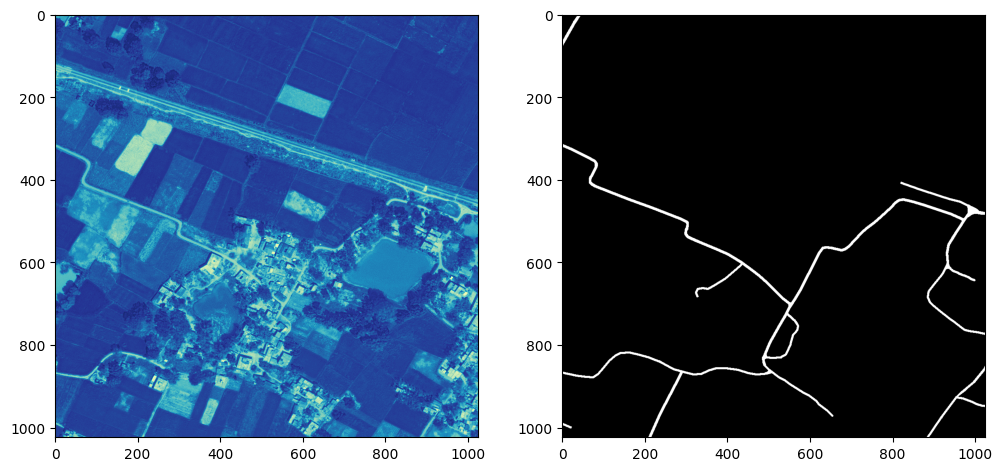

In [27]:
#Sanity check, view few mages
image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='YlGnBu_r')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

##### UNET Architecture

In [28]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

In [29]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x


#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [30]:
#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [31]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

print(IMG_HEIGHT)
print(IMG_WIDTH )
print(IMG_CHANNELS)

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

1024
1024
1


In [32]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2024-03-06 12:16:25.944796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46872 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:04:00.0, compute capability: 8.6


sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 1024, 64)       640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 1024, 64)       256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 1024, 1024, 64)       0         ['batch_normalizat

In [33]:
!nvidia-smi

Wed Mar  6 12:16:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:04:00.0 Off |                  Off |
| 30%   33C    P2              69W / 300W |  47144MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [34]:
history = model.fit(X_train, y_train,
                    batch_size = 2,
                    verbose = 1,
                    epochs = 30,
                    validation_data = (X_test, y_test),
                    shuffle = False)

Epoch 1/30


2024-03-06 12:16:57.316758: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-03-06 12:17:09.237692: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1c7797cd40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-06 12:17:09.237751: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-03-06 12:17:09.258311: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709727429.401631    1759 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 [==============================] - 63s 462ms/step - loss: 0.5146 - accuracy: 0.8232 - val_loss: 0.6550 - val_accuracy: 0.9461
Epoch 2/30
40/40 [==============================] - 17s 426ms/step - loss: 0.4429 - accuracy: 0.8976 - val_loss: 0.6072 - val_accuracy: 0.9461
Epoch 3/30
40/40 [==============================] - 17s 419ms/step - loss: 0.3842 - accuracy: 0.9335 - val_loss: 0.5255 - val_accuracy: 0.9461
Epoch 4/30
40/40 [==============================] - 17s 420ms/step - loss: 0.3392 - accuracy: 0.9475 - val_loss: 0.4327 - val_accuracy: 0.9461
Epoch 5/30
40/40 [==============================] - 17s 419ms/step - loss: 0.3033 - accuracy: 0.9534 - val_loss: 0.3558 - val_accuracy: 0.9461
Epoch 6/30
40/40 [==============================] - 17s 417ms/step - loss: 0.2751 - accuracy: 0.9562 - val_loss: 0.3025 - val_accuracy: 0.9461
Epoch 7/30
40/40 [==============================] - 17s 422ms/step - loss: 0.2532 - accuracy: 0.9575 - val_loss: 0.2708 - val_accuracy: 0.9461
Epoch 8/30

In [35]:
model.save('30epochs.hdf5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
model.save('30epochs.keras')

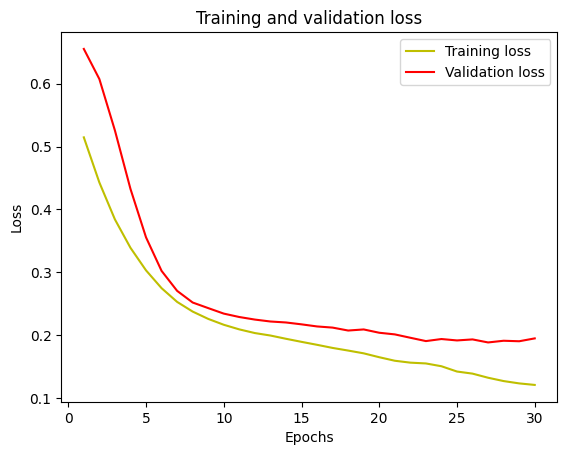

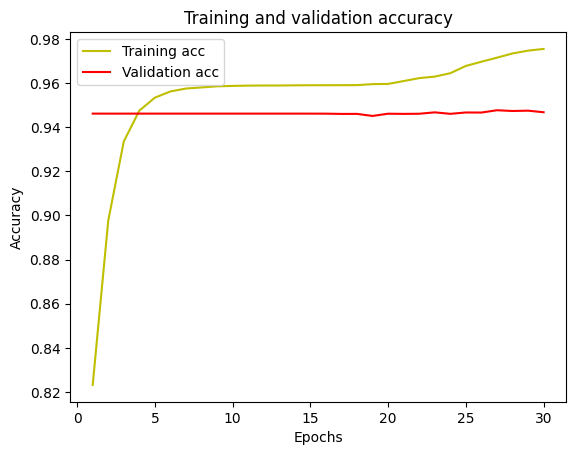

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
#Load previously saved model
from keras.models import load_model
model2 = load_model('30epochs.hdf5')

In [40]:
#IOU
y_pred=model2.predict(X_test)
y_pred_thresholded = y_pred > 0.5

2024-03-06 12:30:11.925542: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


1/1 [==============================] - 66s 66s/step


In [41]:
from tensorflow.keras.metrics import MeanIoU

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.48315087


##### Tests

(1, 1024, 1024, 1)
1/1 [==============================] - 6s 6s/step
(1024, 1024)


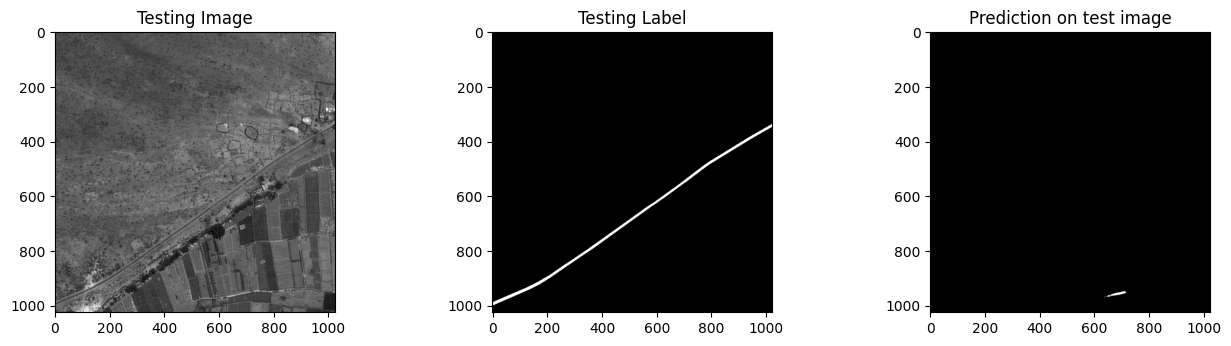

In [42]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

(1, 1024, 1024, 1)
1/1 [==============================] - 0s 42ms/step
(1024, 1024)


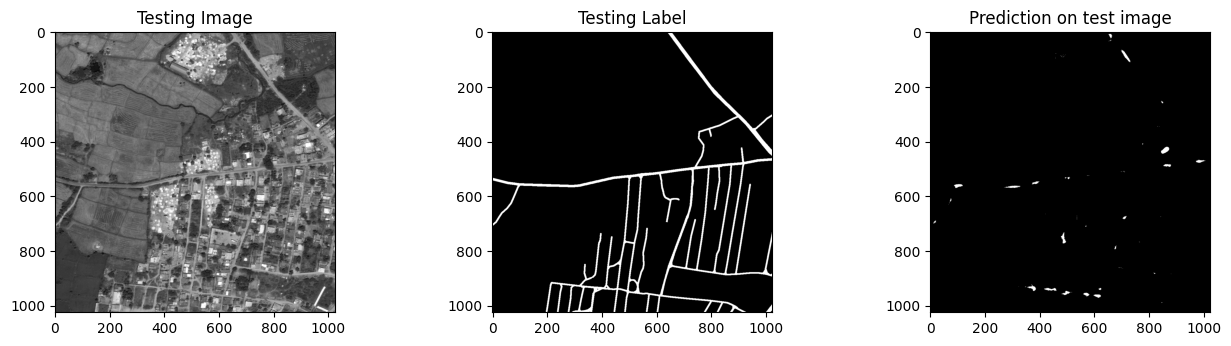

(1, 1024, 1024, 1)
1/1 [==============================] - 0s 34ms/step
(1024, 1024)


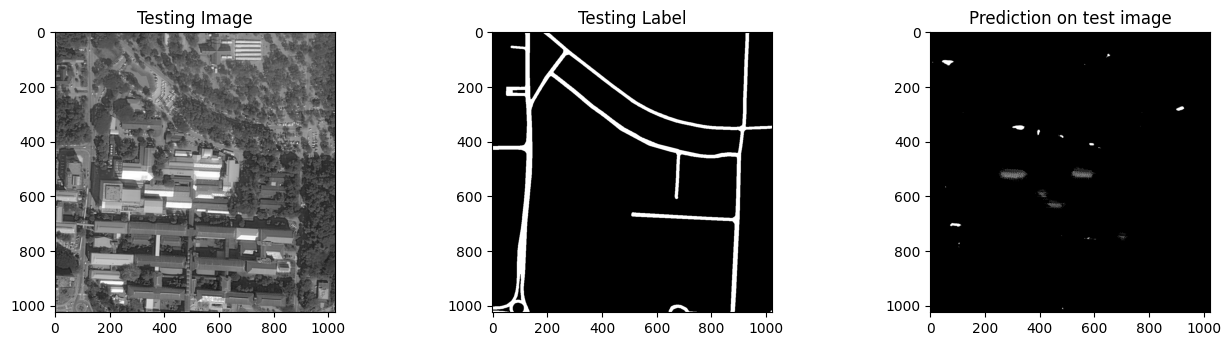

(1, 1024, 1024, 1)
1/1 [==============================] - 0s 37ms/step
(1024, 1024)


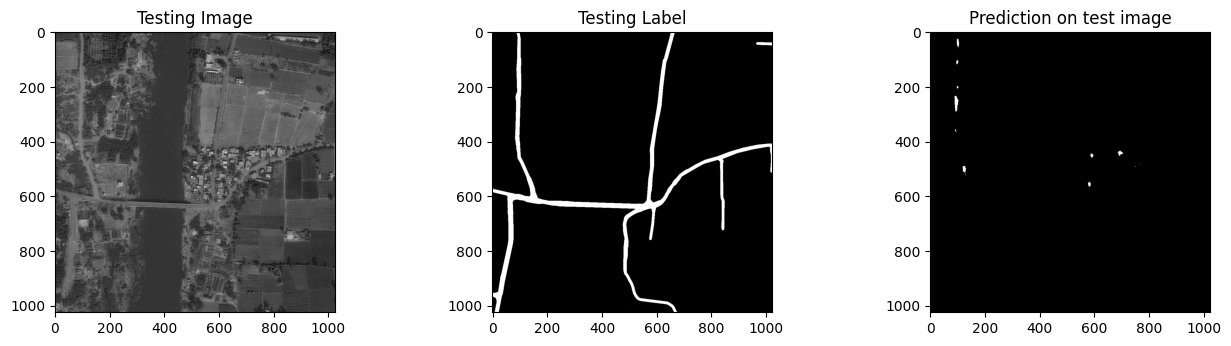

(1, 1024, 1024, 1)
1/1 [==============================] - 0s 36ms/step
(1024, 1024)


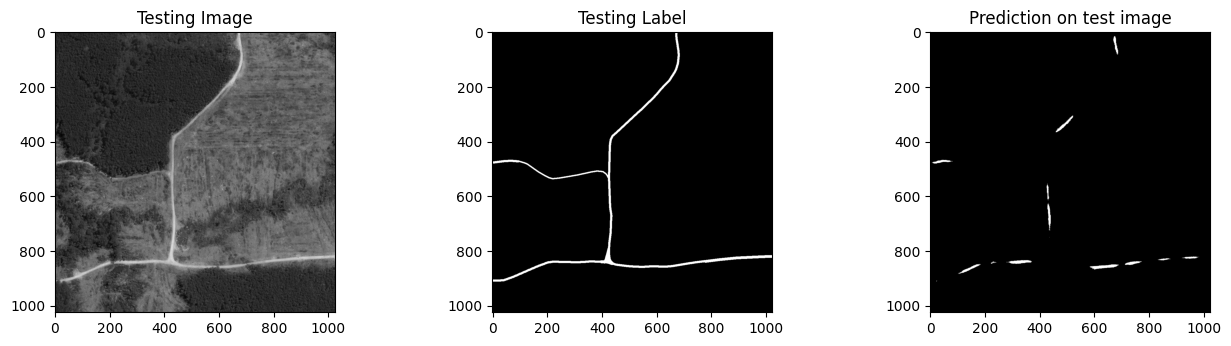

(1, 1024, 1024, 1)
1/1 [==============================] - 0s 34ms/step
(1024, 1024)


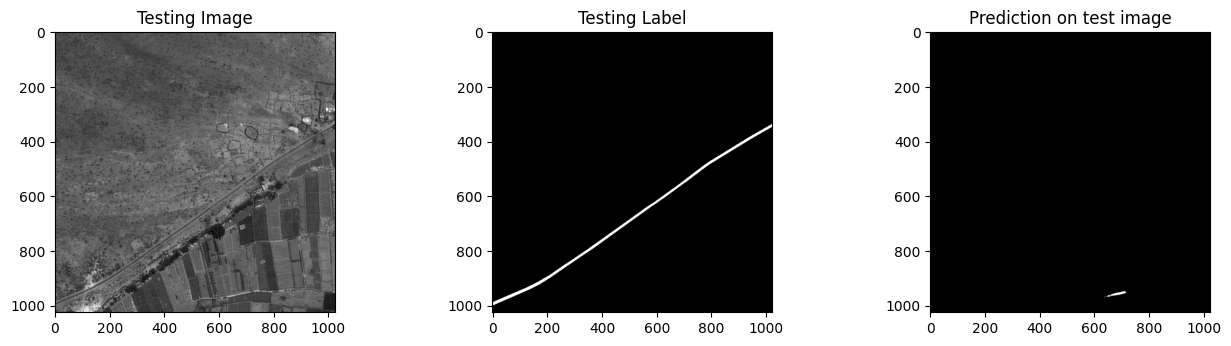

(1, 1024, 1024, 1)
1/1 [==============================] - 0s 34ms/step
(1024, 1024)


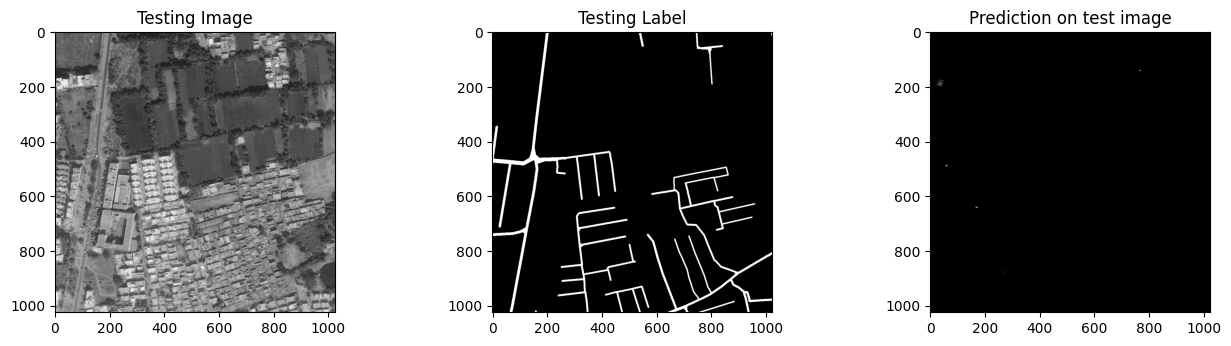

In [46]:
for i in range(6):
    threshold = 0.5
    test_img_number = random.randint(0, len(X_test)-1)
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    print(test_img_input.shape)
    prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    print(prediction.shape)
    
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(prediction, cmap='gray')
    
    plt.show()